<h1>Checkpointing and Restarting</h1>
There are a number of reasons why you might not be able to run a simulation all at once.
Your simulation may take a week to run, but the maximum time in the queue might be only a few hours. Alternatively,
your job might crash after running several hours but only be half finished. Was the preceeding time simply lost? Not
if you make use of the checkpoint restart feature of Cactus.

In [1]:
import os
os.environ["PATH"]="/opt/conda/envs/python2/bin:"+os.environ["PATH"]

In [2]:
!python --version

Python 2.7.13


In [3]:
%cd ~/CactusFW2

/home/jovyan/CactusFW2


First, we're going to start by creating a file named wave3.par. It will differ only slightly from wave.par used in the
compiling and running notebook. You'll find the new bits that relate to checkpointing at the end.

In [4]:
%%writefile wave3.par

#Reorder the parameters for easy comparison to the input.txt in example 3
ActiveThorns = "
  CoordBase FunWave FunwaveCoord CartGrid3D Carpet CarpetIOASCII
  CartGrid3D IOUtil CarpetIOBasic CarpetSlab Boundary SymBase MoL
  CarpetReduce LocalReduce InitBase CarpetLib LoopControl Tridiagonal
  CarpetIOScalar "

#----------------------------------------------------
# Flesh and CCTK parameters
#----------------------------------------------------

# flesh
Cactus::cctk_run_title = "Test Run"
Cactus::cctk_show_schedule = "yes"
Cactus::cctk_itlast = 300
Cactus::allow_mixeddim_gfs = "yes"

# CartGrid3D
CartGrid3D::type = "coordbase"
CartGrid3D::avoid_origin = "no"
CoordBase::domainsize = "minmax"
CoordBase::spacing    = "gridspacing"
CoordBase::xmin =  0
CoordBase::xmax =  30
CoordBase::ymin =  0
CoordBase::ymax =  30
CoordBase::zmin =  0.0
CoordBase::zmax =  0.0
CoordBase::dx   =  0.25
CoordBase::dy   =  0.25

CoordBase::boundary_size_x_lower     = 3
CoordBase::boundary_size_x_upper     = 3
CoordBase::boundary_size_y_lower     = 3
CoordBase::boundary_size_y_upper     = 3
CoordBase::boundary_size_z_lower     = 0
CoordBase::boundary_size_z_upper     = 0
CoordBase::boundary_shiftout_x_lower = 1
CoordBase::boundary_shiftout_x_upper = 1
CoordBase::boundary_shiftout_y_lower = 1
CoordBase::boundary_shiftout_y_upper = 1
CoordBase::boundary_shiftout_z_lower = 1
CoordBase::boundary_shiftout_z_upper = 1

# Carpet
Carpet::domain_from_coordbase = "yes"
Carpet::ghost_size_x = 3
Carpet::ghost_size_y = 3
Carpet::ghost_size_z = 1
carpet::adaptive_stepsize = yes

# MoL
MoL::ODE_Method = "RK3"
MoL::disable_prolongation        = "yes"

# the output dir will be named after the parameter file name
IO::out_dir = $parfile
IO::out_fileinfo="none"
IOBasic::outInfo_every = 1
IOBasic::outInfo_vars = "FunWave::eta FunWave::u FunWave::v"

#IOASCII::out1D_every = 1
#IOASCII::out1d_vars = "FunWave::eta Funwave::depth"
CarpetIOASCII::compact_format = false
IOASCII::out2D_every = 30
IOASCII::out2D_xyplane_z = 0
IOASCII::out2D_vars = "FunWave::eta FunWave::u FunWave::v"
IOASCII::out2D_xz = "no"
IOASCII::out2D_yz = "no"
IOASCII::output_ghost_points = "no"

IOScalar::outScalar_every = 1
IOScalar::outScalar_vars = "FunWave::eta FunWave::u FunWave::v"

#& = "Funwave::eta"

#----------------------------------------------------
# Funwave parameters
#----------------------------------------------------

# Funwave depth 
FunWave::depth_file_offset_x = 3
FunWave::depth_file_offset_y = 3
FunWave::depth_type = "flat"
FunWave::depth_format = "ele"
FunWave::depth_file = "/tmp/__depth__.txt"
FunWave::depth_flat = 0.8
#Funwave::test_depth_shore_x = 80
#Funwave::test_depth_island_x = 40
#Funwave::test_depth_island_y = 40
FunWave::depth_xslp = 10.0
FunWave::depth_slope = 0.05
FunWave::dt_size = 0
Funwave::generate_test_depth_data = true
Funwave::num_wave_components = 1
Funwave::wave_component_file = "/home/sbrandt/workspace/shi_funwave/example_2/fft/wavemk_per_amp_pha.txt"
Funwave::peak_period = 1

# import
Funwave::time_ramp = 1.0
Funwave::delta_wk = 0.5
Funwave::dep_wk = 0.45
Funwave::xc_wk = 3.0
Funwave::ywidth_wk = 10000.0
Funwave::tperiod = 1.0
Funwave::amp_wk = 0.0232
Funwave::theta_wk = 0.0
Funwave::freqpeak = 0.2
Funwave::freqmin = 0.1
Funwave::freqmax = 0.4
Funwave::hmo = 1.0
Funwave::gammatma = 5.0
Funwave::thetapeak = 10.0
Funwave::sigma_theta = 15.0

# Funwave wind forcing
Funwave::wind_force = false
Funwave::use_wind_mask = false
Funwave::num_time_wind_data = 2
Funwave::timewind[0] = 0
Funwave::wu[0] = 25
Funwave::wv[0] = 50
Funwave::timewind[1] = 1000
Funwave::wu[1] = 100
Funwave::wv[1] = 100
Funwave::boundary = funwave

# Funwave wave maker
FunWave::wavemaker_type = "ini_gau"
FunWave::xc = 26.5
FunWave::yc = 26.9
FunWave::amp =  2.0
FunWave::wid =  1
Funwave::wdep = 0.78
Funwave::xwavemaker = 25.0

# Funwave sponge 
FunWave::sponge_on = false
FunWave::sponge_west_width = 2.0
FunWave::sponge_east_width = 2.0
FunWave::sponge_north_width = 0.0
FunWave::sponge_south_width = 0.0
FunWave::sponge_decay_rate = 0.9
FunWave::sponge_damping_magnitude = 5.0

# Funwave dispersion (example 3 enables dispersion)
FunWave::dispersion_on = "true"
FunWave::gamma1 = 1.0
FunWave::gamma2 = 1.0
FunWave::gamma3 = 1.0
FunWave::beta_ref = -0.531
FunWave::swe_eta_dep = 0.80
FunWave::cd = 0.0

# Funwave numerics (MoL parameter controls time integration scheme)
FunWave::reconstruction_scheme = "fourth"
FunWave::riemann_solver = "HLLC"
FunWave::dtfac = 0.5
FunWave::froudecap = 10.0
FunWave::mindepth = 0.001
FunWave::mindepthfrc = 0.001
FunWave::enable_masks = "true"
Funwave::estimate_dt_on = "true"

FunwaveCoord::spherical_coordinates = false

ActiveThorns = "CarpetIOHDF5"
IOHDF5::out2D_xyplane_z = 0 
IOHDF5::out2D_every = 10
IOHDF5::out2D_vars = " 
  FunWave::eta
  FunWave::u
  FunWave::v
  Grid::Coordinates{out_every=1000000000}
"
IOHDF5::out2D_xz = no
IOHDF5::out2D_yz = no

# Turn checkpointing on
IOHDF5::checkpoint = yes

# If you have a long running simulation,
# you might want to set this to checkpoint
# frequently enough that you don't either
# spend too much time checkpointing, or (in
# the event of a crash) spend too much time
# recalculating.
IO::checkpoint_every_walltime_hours = 0.5
        
# If you think you might want to continue
# your simulation.
IO::checkpoint_on_terminate = yes

# This setting tells Cactus to resume from
# a checkpoint file if one exists
IO::recover = autoprobe

# This setting tells Cactus where to write
# its checkpoint files.
IO::checkpoint_dir = ".."
# Thiis setting tells Cactus where to read
# its checkpoint files from.
IO::recover_dir = ".."

Overwriting wave3.par


When we studied compiling and running cactus we used "run-submit" to run our job interactively. If you are going to
make use of a supercomputer, you cannot work this way, you have to submit to a job queue and wait for your job to finish.
Simfactory simplifies this task as well, so that you don't need to know which job scheduler a given machine has or
what its quirks are. If you are running on a machine without a queueing system, however, Simfactory simply runs the job in the background. That's what happens here.

In [5]:
!rm -fr ~/simulations/wave3
!./simfactory/bin/sim create-submit wave3.par --procs=2 --num-threads=1

Parameter file: /home/jovyan/CactusFW2/wave3.par
Skeleton Created
Job directory: "/home/jovyan/simulations/wave3"
Executable: "/home/jovyan/CactusFW2/exe/cactus_sim"
Option list: "/home/jovyan/simulations/wave3/SIMFACTORY/cfg/OptionList"
Submit script: "/home/jovyan/simulations/wave3/SIMFACTORY/run/SubmitScript"
Run script: "/home/jovyan/simulations/wave3/SIMFACTORY/run/RunScript"
Parameter file: "/home/jovyan/simulations/wave3/SIMFACTORY/par/wave3.par"
Assigned restart id: 0 
Executing submit command: exec nohup /home/jovyan/simulations/wave3/output-0000/SIMFACTORY/SubmitScript < /dev/null > /dev/null 2> /dev/null & echo $!
Submit finished, job id is 17759


The next command tells you the status of a job. You can run it repeatedly....

In [6]:
!./simfactory/bin/sim list-sim wave3 

   wave3                   [ACTIVE (RUNNING), restart 0000, job id 17759]


You can create a small python script that checks for you.

In [7]:
import os
import re
import sys
import time
while True:
    c = os.popen("./simfactory/bin/sim list-sim wave3").read()
    sys.stdout.write(c)
    sys.stdout.flush()
    time.sleep(3)
    if re.search("FINISHED",c):
        break

   wave3                   [ACTIVE (RUNNING), restart 0000, job id 17759]
   wave3                   [ACTIVE (RUNNING), restart 0000, job id 17759]
   wave3                   [ACTIVE (RUNNING), restart 0000, job id 17759]
   wave3                   [ACTIVE (RUNNING), restart 0000, job id 17759]
   wave3                   [ACTIVE (RUNNING), restart 0000, job id 17759]
   wave3                   [ACTIVE (RUNNING), restart 0000, job id 17759]
   wave3                   [ACTIVE (RUNNING), restart 0000, job id 17759]
   wave3                   [ACTIVE (RUNNING), restart 0000, job id 17759]
   wave3                   [ACTIVE (FINISHED), restart 0000, job id 17759]


All the next command does is change the number of iterations the simulation requires. You don't have to use perl, but
I happen to like it. Remember, changing a file in place with perl is as easy as pie (i.e. "perl -p -i -e").

In [8]:
!perl -p -i -e 's{Cactus::cctk_itlast\s+=\s+\d+}{Cactus::cctk_itlast = 400}' wave3.par

Unfortunately, for the purpose of restarting the job, Simfactory won't see the change we just made unless we
copy it to the appropriate directory. Of course, we could have run the perl command on that file instead.

In [9]:
!cp wave3.par /home/jovyan/simulations/wave3/SIMFACTORY/par/wave3.par

The next command restarts from the checkpoint file and continues.

In [10]:
!./simfactory/bin/sim submit wave3.par --procs=2 --num-threads=1

Assigned restart id: 1 
Executing submit command: exec nohup /home/jovyan/simulations/wave3/output-0001/SIMFACTORY/SubmitScript < /dev/null > /dev/null 2> /dev/null & echo $!
Submit finished, job id is 17895


Note that the job number is now 0001 instead of 0000. It increments for each restart, as many as you have.

In [11]:
import os
import re
import sys
import time
while True:
    c = os.popen("./simfactory/bin/sim list-sim wave3").read()
    sys.stdout.write(c)
    sys.stdout.flush()
    time.sleep(3)
    if re.search("FINISHED",c):
        break

   wave3                   [ACTIVE (RUNNING), restart 0001, job id 17895]
   wave3                   [ACTIVE (RUNNING), restart 0001, job id 17895]
   wave3                   [ACTIVE (RUNNING), restart 0001, job id 17895]
   wave3                   [ACTIVE (RUNNING), restart 0001, job id 17895]
   wave3                   [ACTIVE (FINISHED), restart 0001, job id 17895]


The code snippets below to plot the results were modified slightly from the compiling and running notebook. The x and y
data files are taken from the 0000 directory, but the data is taken from the 0001 directory.

In [12]:
# This cell enables inline plotting in the notebook
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt

In [13]:
import matplotlib.cm as cm
# https://matplotlib.org/examples/color/colormaps_reference.html
cmap = cm.gist_rainbow

In [14]:
import h5py
import re

In [15]:
%cd ~/simulations/wave3/

/home/jovyan/simulations/wave3


In [16]:
f5x = h5py.File("output-0000/wave3/x.xy.h5")
f5y = h5py.File("output-0000/wave3/y.xy.h5")
x_coords = {}
y_coords = {}
for nm in f5x:
    print(nm)
    m = re.search(r'rl=.*c=\d+',nm)
    if m:
        k = m.group(0)
        x_coords[k]=np.copy(f5x[nm])
for nm in f5y:
    m = re.search(r'rl=.*c=\d+',nm)
    if m:
        k = m.group(0)
        y_coords[k]=np.copy(f5y[nm])

GRID::x it=0 tl=0 rl=0 c=0
GRID::x it=0 tl=0 rl=0 c=1
Parameters and Global Attributes


iteration= 300


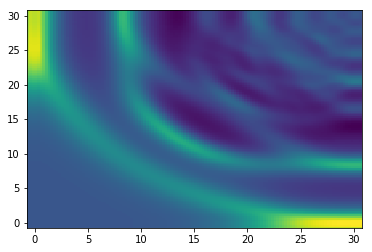

iteration= 310


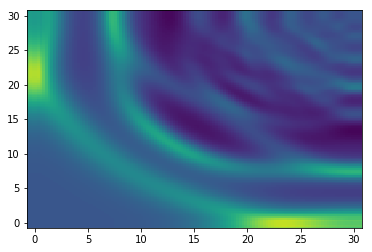

iteration= 320


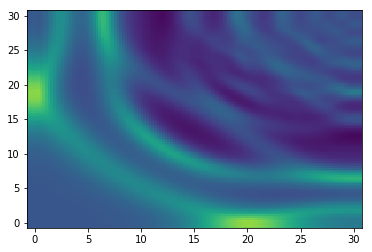

iteration= 330


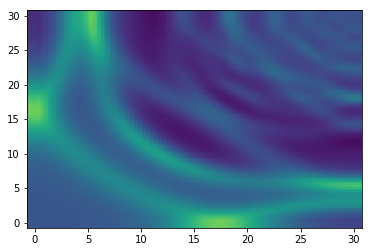

iteration= 340


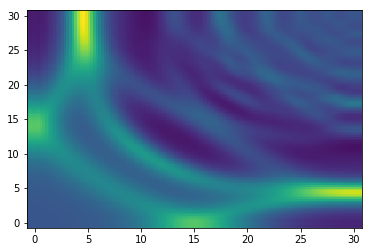

iteration= 350


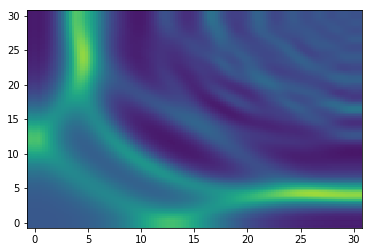

iteration= 360


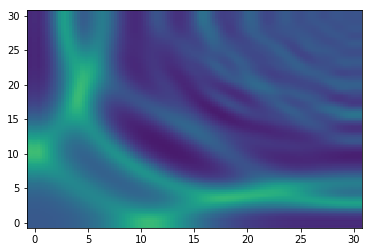

iteration= 370


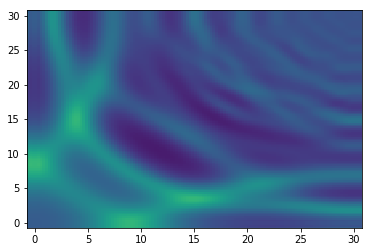

iteration= 380


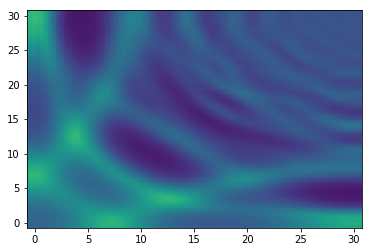

iteration= 390


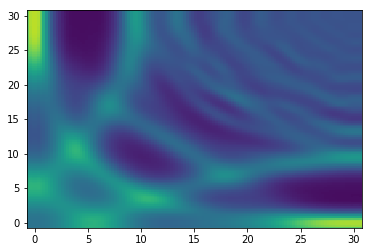

iteration= 400


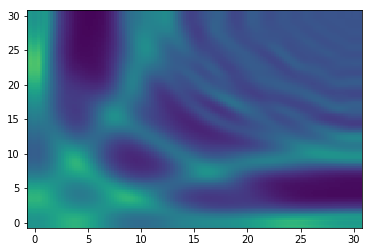

In [17]:
f5 = h5py.File("output-0001/wave3/eta.xy.h5")
mn,mx = None,None

# Compute the min and max
for nm in f5:
    if not hasattr(f5[nm],"shape"):
        continue
    d5 = np.copy(f5[nm])
    tmin = np.min(d5)
    tmax = np.max(d5)
    if mn == None:
        mn,mx = tmin,tmax
    else:
        if tmin < mn:
            mn = tmin
        if tmax > mx:
            mx = tmax
            
# Collect all the pieces into the d5_tl dictionary
d5_tl = {}            
for nm in f5:
    if not hasattr(f5[nm],"shape"):
        continue
    # Parse the string nm...
    m = re.search(r'it=(\d+)\s+tl=\d+\s+(rl=(\d+)\s+c=(\d+))',nm)
    if not m:
        print("nm=",nm)
        continue
    # group(1) is the iteration number
    # group(2) is "rl={number} c={number}"
    # group(3) is the number in "rl={number}"
    # group(4) is the number in "c={number}"
    grid = int(m.group(1))
    comp = int(m.group(4))
    k = m.group(2)
    if grid in d5_tl:
        d5_tl[grid]["x"] += [x_coords[k]] # append to the x array
        d5_tl[grid]["y"] += [y_coords[k]] # append to the y array
        d5_tl[grid]["D"] += [f5[nm]] # append to the data array
    else:
        d5_tl[grid] = {
            "x":[x_coords[k]],
            "y":[y_coords[k]],
            "D":[f5[nm]]
        }

# Sort the keys so that we display time levels in order
def keysetf(d):
    a = [] # create an empty list
    for k in d: # for each key in d
        a.append(k) # append it to the list
    return a
kys = keysetf(d5_tl.keys())
kys.sort()

# Show the figures, combing data from the same time level
for index in kys:
    data = d5_tl[index]
    print("iteration=",index)
    plt.figure() # put this before the plots you wish to combine
    plt.pcolor(data["x"][0],data["y"][0],data["D"][0],vmin=mn,vmax=mx)
    plt.pcolor(data["x"][1],data["y"][1],data["D"][1],vmin=mn,vmax=mx)
    plt.show() # show the plot.f5 = h5py.File("u.xy.h5")

Exercise:
Using the existing checkpoint files, continue the evolution to timestemp 500 and plot the results.